# Dataset Preparation

# Imports

In [145]:
# Import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, random_split, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import Resize, InterpolationMode
from torchsummary import summary
from torchmetrics import Accuracy, Precision, Recall, F1Score
from torchaudio.transforms import MelSpectrogram
import librosa
from sklearn.metrics import ConfusionMatrixDisplay
from torchmetrics import ConfusionMatrix
import wandb
from tqdm import tqdm
import os


# Helper functions

In [146]:
def plot_spectogram(specgram, title=None, ylabel='freq_bin'):
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin='lower', aspect='auto')

def plot_history(history, net_name):
    x_ticks = range(1, len(history['train']['loss']) + 1)
    for item in history['train'].keys():
        plt.figure(figsize=(12, 4))
        for prefix, color in zip(['train', 'val'], ['r', 'b']):
            plt.plot(x_ticks, history[prefix][item], c=color, alpha=0.75, linestyle='--',
                     label=prefix)
        plt.title('{} {}'.format(net_name, item))
        plt.xlabel('Epoch')
        plt.xticks(x_ticks)
        plt.ylabel(item)
        plt.grid()
        plt.legend()
        plt.show()

def plot_metric_values(metric_values, net_name):
    for item in metric_values:
        fig, ax = plt.subplots(figsize=(12, 4))
        x = range(metric_values[item].shape[0])
        mean = metric_values[item].mean()
        bars = ax.bar(x, metric_values[item])
        
        ax.axhline(mean, color='r', linestyle=':')
        for bar in bars:
            height = bar.get_height()
            
            ax.text(bar.get_x() + bar.get_width() / 2, height, '{:.2}'.format(height),
                    ha='center', va='bottom')
        ax.set_xlabel('Class')
        ax.set_xticks(x)
        ax.set_title('{} {} on test'.format(net_name, item))
        plt.show()

def generate_confusion_matrix(net, dataloader, device, num_classes, idx_to_class,
                              title="Confusion Matrix", save_path=None, log_to_wandb=True):
    """
    Generates and plots a confusion matrix for the given network and dataloader.

    Args:
        net: The trained PyTorch model.
        dataloader: The PyTorch DataLoader for the dataset (e.g., test_dl).
        device: The device ('cuda' or 'cpu') the model and data are on.
        num_classes: The total number of classes.
        idx_to_class: A dictionary mapping integer class indices to string class names.
                      (e.g., {0: 'class_a', 1: 'class_b', ...}).
        title: The title for the confusion matrix plot.
        save_path: Optional path to save the plot image (e.g., 'confusion_matrix.png').
        log_to_wandb: Whether to log the confusion matrix to Weights & Biases.
    """
    net.to(device)
    net.eval()

    confmat = ConfusionMatrix(task='multiclass', num_classes=num_classes).to(device)

    print("Generating confusion matrix...")

    # Iterate through the dataloader and update the confusion matrix metric
    with torch.no_grad():
        # Using tqdm again to show progress during confusion matrix generation
        for X, y in tqdm(dataloader, desc="Calculating Confusion Matrix"):
            if X is None or y is None:
                 continue

            X = X.to(device)
            y = y.to(device)

            preds = net(X)
            confmat.update(preds, y)

    confusion_matrix_tensor = confmat.compute()

    confusion_matrix_np = confusion_matrix_tensor.cpu().numpy()

    class_names = [idx_to_class[i] for i in range(num_classes)]

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))

    # Use ConfusionMatrixDisplay for easy plotting
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_np, display_labels=class_names)

    # Customize the plot
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
    ax.set_title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        try:
            plt.savefig(save_path, dpi=300)
            print(f"Confusion matrix plot saved to {save_path}")
        except Exception as e:
            print(f"Error saving confusion matrix plot to {save_path}: {e}")


    # Log the plot to Weights & Biases if log_to_wandb is True
    if log_to_wandb:
        try:
            wandb.log({"confusion_matrix": wandb.Image(plt)})
            print("Confusion matrix plot logged to W&B.")
        except Exception as e:
            print(f"Error logging confusion matrix to W&B: {e}")

    plt.close(fig)

# Load dataset

In [129]:
class LoadedSpectrogramDataset(Dataset):
    """
    A PyTorch Dataset to load processed spectrogram tensors saved in
    a directory structure like:
    base_dir/
    ├── class_label_1/
    │   ├── file1.pt
    │   ├── file2.pt
    │   └── ...
    ├── class_label_2/
    │   ├── fileA.pt
    │   └── ...
    └── ...
    """
    def __init__(self, data_base_dir: str):
        """
        Args:
            data_base_dir: The path to the base directory containing the class subdirectories
                           with saved .pt files (e.g., 'RawFreqMasking').
        """
        self.data_base_dir = data_base_dir
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        self._load_files()

    def _load_files(self):
        """Scans the data_base_dir to find all .pt files and their class labels."""
        print(f"Scanning directory: {os.path.abspath(self.data_base_dir)}")

        # Get a list of potential class directories (first level subdirectories)
        class_dirs = [d for d in os.listdir(self.data_base_dir)
                      if os.path.isdir(os.path.join(self.data_base_dir, d))]

        # Sort class directories to ensure consistent class_to_idx mapping
        class_dirs.sort()

        # Create class_to_idx and idx_to_class mappings
        for idx, class_name in enumerate(class_dirs):
            self.class_to_idx[class_name] = idx
            self.idx_to_class[idx] = class_name

        print(f"Found {len(class_dirs)} classes: {list(self.class_to_idx.keys())}")

        # Iterate through class directories and find all .pt files
        for class_name in tqdm(class_dirs, desc="Loading file paths"):
            class_dir_path = os.path.join(self.data_base_dir, class_name)
            class_label_int = self.class_to_idx[class_name]

            # List all files in the class directory
            files_in_class_dir = os.listdir(class_dir_path)

            # Filter for .pt files and store their full paths and integer labels
            for filename in files_in_class_dir:
                if filename.endswith('.pt'):
                    file_path = os.path.join(class_dir_path, filename)
                    # Store (full_file_path, integer_class_label)
                    self.samples.append((file_path, class_label_int))

        print(f"Total files found: {len(self.samples)}")


    def __getitem__(self, idx):
        """
        Loads and returns a single sample from the dataset.

        Args:
            idx: The index of the sample to retrieve.

        Returns:
            A tuple containing:
            - specgram: The loaded spectrogram tensor (torch.Tensor).
            - class_label: The integer class label (int).
        """
        if idx >= len(self):
            raise IndexError("Index out of bounds")

        file_path, class_label_int = self.samples[idx]

        try:
            # Load the tensor from the .pt file
            specgram = torch.load(file_path)

            return specgram, class_label_int

        except Exception as e:
            print(f"Error loading sample {file_path}: {e}")

            # Let's return None and require manual handling in the DataLoader loop
            return None, None


    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.samples)

In [130]:
ds = LoadedSpectrogramDataset('../dataset/BilateralWithoutDataAugmentation')
n_classes = len(ds.class_to_idx.keys())
print(f"Loaded dataset contains {len(ds)} samples")
print(f"Number of classes: {n_classes}")
sample = ds[12304]
print(f"Sample shape: {sample[0].shape} class: {sample[1]}")

Scanning directory: /Users/bitfalt/Developer/IA-Project2/dataset/BilateralWithoutDataAugmentation
Found 10 classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Loading file paths: 100%|██████████| 10/10 [00:00<00:00, 83.31it/s]

Total files found: 30000
Loaded dataset contains 30000 samples
Number of classes: 10
Sample shape: torch.Size([1, 24, 48]) class: 4


# Create dataset

In [131]:
n_channels = 1
n_mels = 24
time = 48
sample_rate = 48000

transform = torch.nn.Sequential(
    MelSpectrogram(sample_rate, n_fft=1024, n_mels=n_mels),
    Resize(size=(n_mels, time), interpolation=InterpolationMode.NEAREST)
)

In [132]:
batch_size = 64

train_ds, val_ds, test_ds = random_split(ds, [0.7, 0.15, 0.15])

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

# Model A (LeNet5)

In [133]:
class LeNet5(torch.nn.Sequential):
    def __init__(self, n_channels, n_classes):
        super().__init__(
            torch.nn.Conv2d(in_channels=n_channels, out_channels=6, kernel_size=5),
            torch.nn.AvgPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            torch.nn.AvgPool2d(kernel_size=2),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=432, out_features=120),
            torch.nn.Linear(in_features=120, out_features=84),
            torch.nn.Linear(in_features=84, out_features=n_classes)
        )

In [134]:
net = LeNet5(n_channels=n_channels, n_classes=n_classes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device)

summary(net, (n_channels, n_mels, time))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 20, 44]             156
         AvgPool2d-2            [-1, 6, 10, 22]               0
            Conv2d-3            [-1, 16, 6, 18]           2,416
         AvgPool2d-4             [-1, 16, 3, 9]               0
           Flatten-5                  [-1, 432]               0
            Linear-6                  [-1, 120]          51,960
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 65,546
Trainable params: 65,546
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.25
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


In [135]:
run = wandb.init(
    entity="bitfalt-itcr",
    project="bilateral-without-data-augmentation-hyperparameter-tuning",
    config={
        "learning_rate": 0.0008,
        "epochs": 25,
    },
    tags=["Model A", "LeNet5", "MNIST Audio", "Bilateral", "Without Data Augmentation"],
    notes="Run to find optimal hyperparameters"
)

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch,▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇███
Train Loss,█▅▅▅▅▄▄▃▃▃▃▃▃▅▅▅▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▁▁
Train accuracy,▁▅▅▆▆▆▆▇▇▇▇▇▇▇██▇███
Train f1-score,▁▅▅▆▆▆▆▇▇▇▇▇▇▇██▇███
Train precision,▁▅▆▆▆▆▆▇▇▇▇▇▇▇██████
Train recall,▁▅▅▆▆▆▆▇▇▇▇▇▇▇██▇███
Val Loss,▄▄▄██▄▄▃▃▃▄▄▄▄▃▂▂▂▁▁▁▁▁▁▄▁▁▂▂▂▁▁▂▂▂▂▁▁▁▁
Val accuracy,▂▁▄▄▅▄▄▆▇▇▇▆▇▇█▇▇▇██
Val f1-score,▂▁▄▅▅▄▄▆▇▇▇▆▇▇█▇▇▇██
Val precision,▂▁▄▄▅▄▄▆▇▇▇▆▇▇█▇▇▇██
Val recall,▂▁▄▄▅▄▄▆▇▇▇▆▇▇█▇▇▇██


In [136]:
wandb.watch(net)

In [137]:
def eval(net, eval_dl, prefix, criterion, metrics, device):
    eval_loss = torch.tensor(0.0).to(device)
    eval_metric_values = {
        metric: torch.zeros(metrics[metric].num_classes if metrics[metric].average is None
                            else 1).to(device) for metric in metrics
    }
    
    net.to(device)
    net.eval()
    with torch.no_grad():
        for X, y in eval_dl:
            X = X.to(device)
            y = y.to(device)
            
            preds = net(X)
            loss = criterion(preds, y)
            
            eval_loss += loss.detach().cpu() * eval_dl.batch_size
            for metric in metrics:
                eval_metric_values[metric] += metrics[metric](preds, y) * \
                    eval_dl.batch_size
    
    eval_loss /= len(eval_dl.dataset)
    for metric in metrics:
        eval_metric_values[metric] /= len(eval_dl.dataset)
    
    print('{}_loss: {:.3f}'.format(prefix, eval_loss), end='')
    for metric in metrics:
        print(', {}_{}: {:.3f}'.format(prefix, metric, eval_metric_values[metric].mean()),
              end='')
        
        if prefix == 'test':
            lossKey = f"{prefix} Loss"
            metricKey = f"{prefix} {metric}"
            wandb.log({
                lossKey: eval_loss,
                metricKey: eval_metric_values[metric].mean(),
            })
    
    return eval_loss, eval_metric_values

In [138]:
def train(net, train_dl, val_dl, n_epochs, criterion, metrics, device, lr):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    history = {
        'train': {'loss': []} | {metric: [] for metric in metrics},
        'val': {'loss': []} | {metric: [] for metric in metrics}
    }
    
    net.to(device)
    for epoch in range(n_epochs):
        train_loss = torch.tensor(0.0).to(device)
        train_metric_values = {
            metric: torch.tensor(0.0).to(device) for metric in metrics
        }
        
        net.train()
        for X, y in tqdm(train_dl, desc='Epoch {}/{}'.format(epoch + 1, n_epochs),
                         total=len(train_dl)):
            X = X.to(device)
            y = y.to(device)
            
            preds = net(X)
            loss = criterion(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                train_loss += loss.detach().cpu() * train_dl.batch_size
                for metric in metrics:
                    train_metric_values[metric] += train_dl.batch_size * \
                        metrics[metric](preds, y)
        
        train_loss /= len(train_dl.dataset)
        for metric in metrics:
            train_metric_values[metric] /= len(train_dl.dataset)
        
        print('train_loss: {:.3f}'.format(train_loss), end=', ')
        for metric in metrics:
            print('train_{}: {:.3f}'.format(metric, train_metric_values[metric]),
                  end=', ')

            wandb.log({
                "Epoch": epoch,
                "Train Loss": train_loss,
                "Train " + metric: train_metric_values[metric],
            })
        
        history['train']['loss'].append(train_loss.cpu().detach().numpy().item())
        for metric in metrics:
            history['train'][metric].append(train_metric_values[metric].cpu().detach() \
                                            .numpy().item())
            
        val_loss, val_metric_values = eval(net, val_dl, prefix='val', criterion=criterion,
                                           metrics=metrics, device=device)
        
        scheduler.step(val_loss)
        
        history['val']['loss'].append(val_loss.cpu().detach().numpy().item())
        for metric in metrics:
            history['val'][metric].append(val_metric_values[metric].cpu().detach() \
                                          .numpy().item())
            wandb.log({
                "Epoch": epoch,
                "Val Loss": val_loss,
                "Val " + metric: val_metric_values[metric],
            })
            
    return history

In [139]:
criterion = torch.nn.CrossEntropyLoss()

train_metrics = {
    'accuracy': Accuracy(task='multiclass', num_classes=int(n_classes),
                         average='macro').to(device),
    'precision': Precision(task='multiclass', num_classes=int(n_classes),
                           average='macro').to(device),
    'recall': Recall(task='multiclass', num_classes=int(n_classes),
                     average='macro').to(device),
    'f1-score': F1Score(task='multiclass', num_classes=int(n_classes),
                        average='macro').to(device)
}

In [140]:
history = train(net, train_dl, val_dl, n_epochs=wandb.config.epochs, criterion=criterion,
                metrics=train_metrics, device=device, lr=wandb.config.learning_rate)

Epoch 1/25: 100%|██████████| 329/329 [00:11<00:00, 28.45it/s]


train_loss: 1.388, train_accuracy: 0.627, train_precision: 0.649, train_recall: 0.627, train_f1-score: 0.595, val_loss: 0.899, val_accuracy: 0.787, val_precision: 0.802, val_recall: 0.787, val_f1-score: 0.767

Epoch 2/25: 100%|██████████| 329/329 [00:09<00:00, 33.26it/s]


train_loss: 1.059, train_accuracy: 0.786, train_precision: 0.801, train_recall: 0.786, train_f1-score: 0.769, val_loss: 0.804, val_accuracy: 0.829, val_precision: 0.833, val_recall: 0.829, val_f1-score: 0.817

Epoch 3/25: 100%|██████████| 329/329 [00:09<00:00, 36.55it/s]


train_loss: 0.868, train_accuracy: 0.803, train_precision: 0.815, train_recall: 0.803, train_f1-score: 0.788, val_loss: 0.765, val_accuracy: 0.813, val_precision: 0.824, val_recall: 0.813, val_f1-score: 0.801

Epoch 4/25: 100%|██████████| 329/329 [00:09<00:00, 34.36it/s]


train_loss: 0.827, train_accuracy: 0.823, train_precision: 0.834, train_recall: 0.823, train_f1-score: 0.808, val_loss: 0.711, val_accuracy: 0.837, val_precision: 0.849, val_recall: 0.837, val_f1-score: 0.826

Epoch 5/25: 100%|██████████| 329/329 [00:09<00:00, 35.75it/s]


train_loss: 0.799, train_accuracy: 0.830, train_precision: 0.840, train_recall: 0.830, train_f1-score: 0.817, val_loss: 0.703, val_accuracy: 0.817, val_precision: 0.830, val_recall: 0.817, val_f1-score: 0.803

Epoch 6/25: 100%|██████████| 329/329 [00:08<00:00, 39.87it/s]


train_loss: 0.693, train_accuracy: 0.838, train_precision: 0.850, train_recall: 0.838, train_f1-score: 0.827, val_loss: 0.686, val_accuracy: 0.850, val_precision: 0.860, val_recall: 0.850, val_f1-score: 0.840

Epoch 7/25: 100%|██████████| 329/329 [00:08<00:00, 41.03it/s]


train_loss: 0.760, train_accuracy: 0.838, train_precision: 0.848, train_recall: 0.838, train_f1-score: 0.825, val_loss: 0.792, val_accuracy: 0.826, val_precision: 0.839, val_recall: 0.826, val_f1-score: 0.810

Epoch 8/25: 100%|██████████| 329/329 [00:08<00:00, 40.90it/s]


train_loss: 0.683, train_accuracy: 0.845, train_precision: 0.853, train_recall: 0.845, train_f1-score: 0.832, val_loss: 0.644, val_accuracy: 0.869, val_precision: 0.874, val_recall: 0.869, val_f1-score: 0.859

Epoch 9/25: 100%|██████████| 329/329 [00:08<00:00, 39.40it/s]


train_loss: 0.665, train_accuracy: 0.856, train_precision: 0.864, train_recall: 0.856, train_f1-score: 0.844, val_loss: 0.643, val_accuracy: 0.865, val_precision: 0.871, val_recall: 0.865, val_f1-score: 0.855

Epoch 10/25: 100%|██████████| 329/329 [00:10<00:00, 31.91it/s]


train_loss: 0.666, train_accuracy: 0.852, train_precision: 0.862, train_recall: 0.852, train_f1-score: 0.842, val_loss: 0.578, val_accuracy: 0.885, val_precision: 0.885, val_recall: 0.885, val_f1-score: 0.874

Epoch 11/25: 100%|██████████| 329/329 [00:26<00:00, 12.23it/s]


train_loss: 0.623, train_accuracy: 0.863, train_precision: 0.870, train_recall: 0.863, train_f1-score: 0.852, val_loss: 0.637, val_accuracy: 0.873, val_precision: 0.880, val_recall: 0.873, val_f1-score: 0.862

Epoch 12/25: 100%|██████████| 329/329 [00:10<00:00, 30.97it/s]


train_loss: 0.561, train_accuracy: 0.872, train_precision: 0.877, train_recall: 0.872, train_f1-score: 0.862, val_loss: 0.582, val_accuracy: 0.892, val_precision: 0.897, val_recall: 0.892, val_f1-score: 0.882

Epoch 13/25: 100%|██████████| 329/329 [00:09<00:00, 36.01it/s]


train_loss: 0.620, train_accuracy: 0.863, train_precision: 0.870, train_recall: 0.863, train_f1-score: 0.851, val_loss: 0.677, val_accuracy: 0.851, val_precision: 0.857, val_recall: 0.851, val_f1-score: 0.841

Epoch 14/25: 100%|██████████| 329/329 [00:09<00:00, 35.24it/s]


train_loss: 0.545, train_accuracy: 0.879, train_precision: 0.882, train_recall: 0.879, train_f1-score: 0.869, val_loss: 0.547, val_accuracy: 0.895, val_precision: 0.894, val_recall: 0.895, val_f1-score: 0.884

Epoch 15/25: 100%|██████████| 329/329 [00:08<00:00, 36.94it/s]


train_loss: 0.512, train_accuracy: 0.883, train_precision: 0.887, train_recall: 0.883, train_f1-score: 0.874, val_loss: 0.532, val_accuracy: 0.911, val_precision: 0.911, val_recall: 0.911, val_f1-score: 0.902

Epoch 16/25: 100%|██████████| 329/329 [00:09<00:00, 35.58it/s]


train_loss: 0.491, train_accuracy: 0.893, train_precision: 0.894, train_recall: 0.893, train_f1-score: 0.884, val_loss: 0.496, val_accuracy: 0.902, val_precision: 0.901, val_recall: 0.902, val_f1-score: 0.892

Epoch 17/25: 100%|██████████| 329/329 [00:10<00:00, 30.90it/s]


train_loss: 0.466, train_accuracy: 0.895, train_precision: 0.899, train_recall: 0.895, train_f1-score: 0.887, val_loss: 0.521, val_accuracy: 0.896, val_precision: 0.902, val_recall: 0.896, val_f1-score: 0.887

Epoch 18/25: 100%|██████████| 329/329 [00:09<00:00, 34.32it/s]


train_loss: 0.509, train_accuracy: 0.893, train_precision: 0.895, train_recall: 0.893, train_f1-score: 0.883, val_loss: 0.566, val_accuracy: 0.867, val_precision: 0.875, val_recall: 0.867, val_f1-score: 0.855

Epoch 19/25: 100%|██████████| 329/329 [00:09<00:00, 36.49it/s]


train_loss: 0.478, train_accuracy: 0.891, train_precision: 0.894, train_recall: 0.891, train_f1-score: 0.881, val_loss: 0.490, val_accuracy: 0.912, val_precision: 0.911, val_recall: 0.912, val_f1-score: 0.903

Epoch 20/25: 100%|██████████| 329/329 [00:09<00:00, 35.13it/s]


train_loss: 0.514, train_accuracy: 0.891, train_precision: 0.895, train_recall: 0.891, train_f1-score: 0.883, val_loss: 0.499, val_accuracy: 0.894, val_precision: 0.901, val_recall: 0.894, val_f1-score: 0.886

Epoch 21/25: 100%|██████████| 329/329 [00:09<00:00, 36.29it/s]


train_loss: 0.493, train_accuracy: 0.892, train_precision: 0.897, train_recall: 0.892, train_f1-score: 0.883, val_loss: 0.513, val_accuracy: 0.902, val_precision: 0.903, val_recall: 0.902, val_f1-score: 0.893

Epoch 22/25: 100%|██████████| 329/329 [00:08<00:00, 38.45it/s]


train_loss: 0.451, train_accuracy: 0.899, train_precision: 0.902, train_recall: 0.899, train_f1-score: 0.891, val_loss: 0.469, val_accuracy: 0.906, val_precision: 0.908, val_recall: 0.906, val_f1-score: 0.898

Epoch 23/25: 100%|██████████| 329/329 [00:08<00:00, 38.59it/s]


train_loss: 0.469, train_accuracy: 0.897, train_precision: 0.901, train_recall: 0.897, train_f1-score: 0.889, val_loss: 0.545, val_accuracy: 0.885, val_precision: 0.897, val_recall: 0.885, val_f1-score: 0.876

Epoch 24/25: 100%|██████████| 329/329 [00:09<00:00, 35.59it/s]


train_loss: 0.463, train_accuracy: 0.893, train_precision: 0.896, train_recall: 0.893, train_f1-score: 0.884, val_loss: 0.462, val_accuracy: 0.918, val_precision: 0.916, val_recall: 0.918, val_f1-score: 0.909

Epoch 25/25: 100%|██████████| 329/329 [00:09<00:00, 35.28it/s]


train_loss: 0.427, train_accuracy: 0.901, train_precision: 0.902, train_recall: 0.901, train_f1-score: 0.892, val_loss: 0.471, val_accuracy: 0.909, val_precision: 0.913, val_recall: 0.909, val_f1-score: 0.901

# Plot history

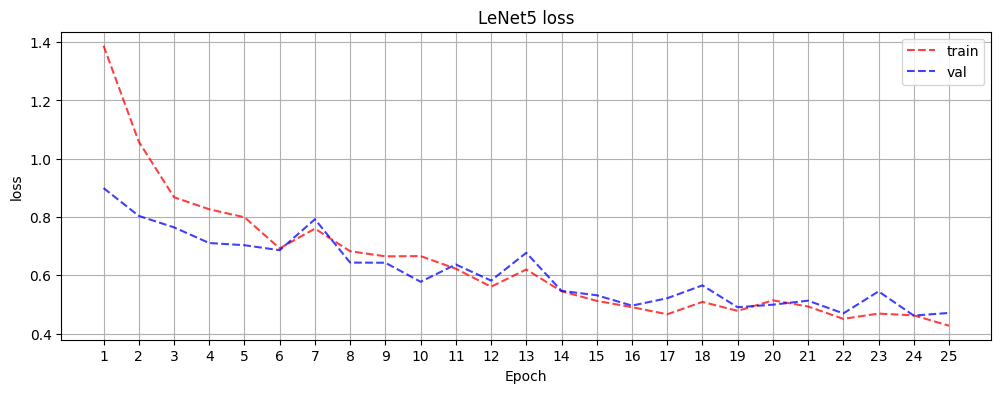

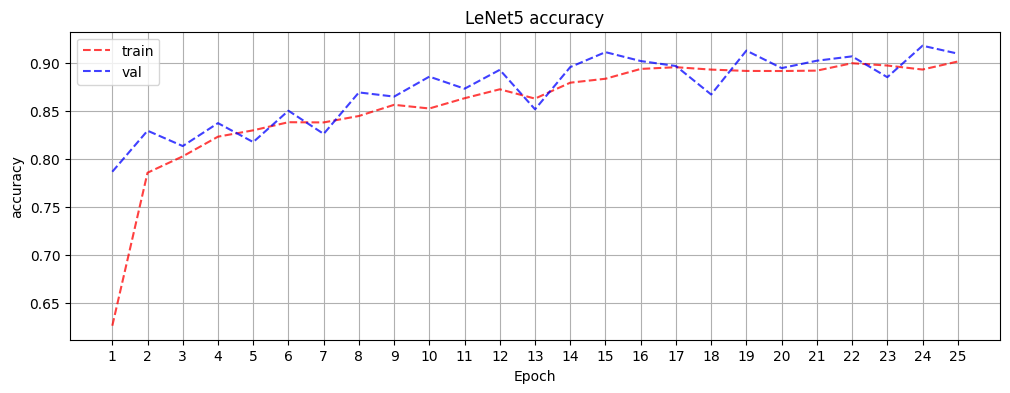

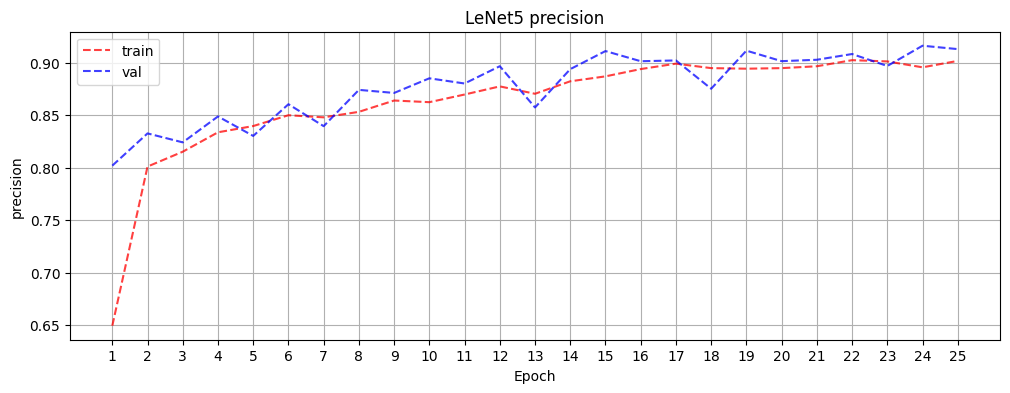

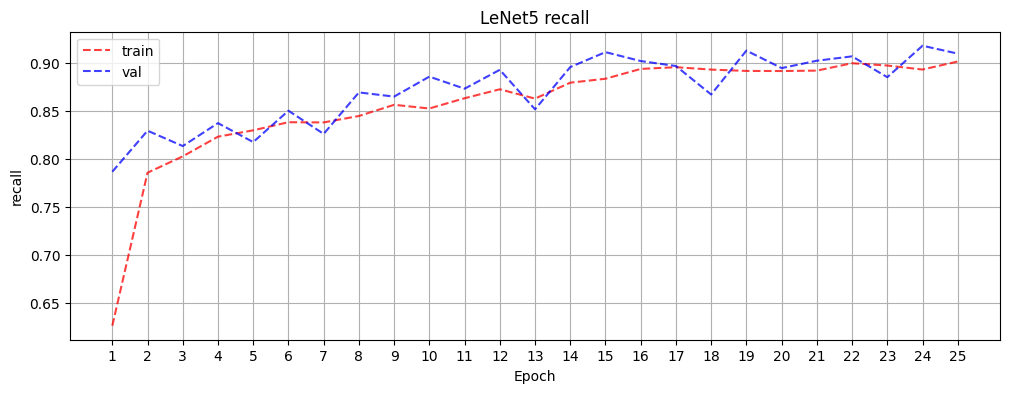

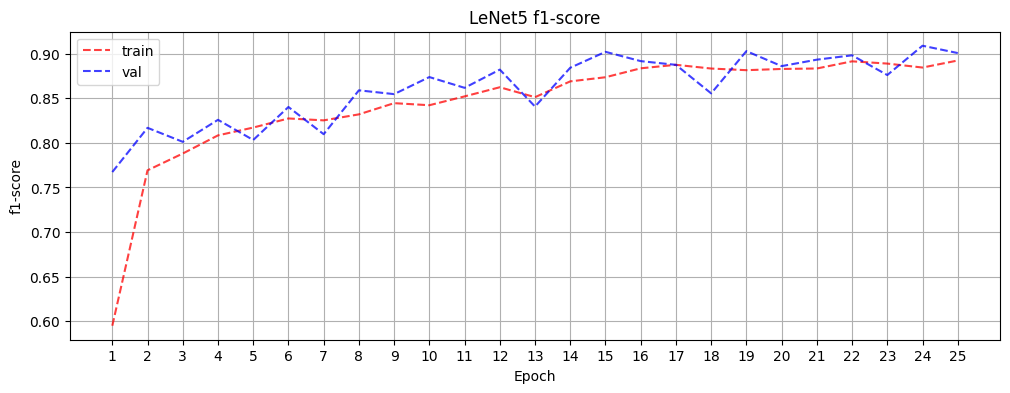

In [141]:
plot_history(history, net_name='LeNet5')

# Evaluate neural network

In [142]:
test_metrics = {
    'accuracy': Accuracy(task='multiclass', num_classes=int(n_classes),
                         average=None).to(device),
    'precision': Precision(task='multiclass', num_classes=int(n_classes),
                           average=None).to(device),
    'recall': Recall(task='multiclass', num_classes=int(n_classes),
                     average=None).to(device),
    'f1-score': F1Score(task='multiclass', num_classes=int(n_classes),
                        average=None).to(device)
}

In [143]:
_, test_metric_values = eval(net, test_dl, prefix='test', criterion=criterion,
                             metrics=test_metrics, device=device)

test_loss: 0.457, test_accuracy: 0.907, test_precision: 0.908, test_recall: 0.907, test_f1-score: 0.897

In [ ]:
if 'loaded_dataset' in locals() and hasattr(loaded_dataset, 'idx_to_class'):
   idx_to_class_mapping = loaded_dataset.idx_to_class
elif 'test_dataset' in locals() and hasattr(test_dataset, 'idx_to_class'):
   idx_to_class_mapping = test_dataset.idx_to_class
else:
   print("Warning: idx_to_class mapping not found. Using integer labels for confusion matrix.")
   idx_to_class_mapping = {i: str(i) for i in range(int(n_classes))}


# Call the function to generate the confusion matrix plot
generate_confusion_matrix(
    net=net,
    dataloader=test_dl,
    device=device,
    num_classes=int(n_classes),
    idx_to_class=idx_to_class_mapping,
    title="Test Set Confusion Matrix",
    save_path="test_confusion_matrix.png",
    log_to_wandb=True
)

Generating confusion matrix...


Calculating Confusion Matrix: 100%|██████████| 71/71 [00:01<00:00, 44.46it/s]


Confusion matrix plot saved to test_confusion_matrix.png


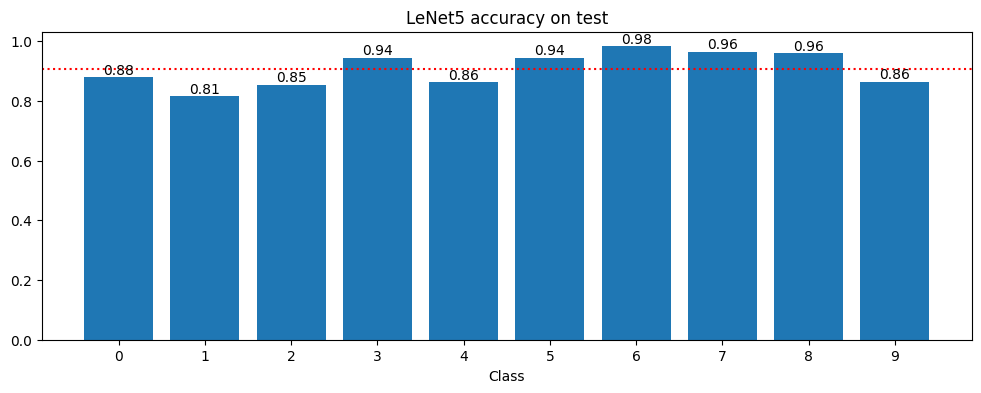

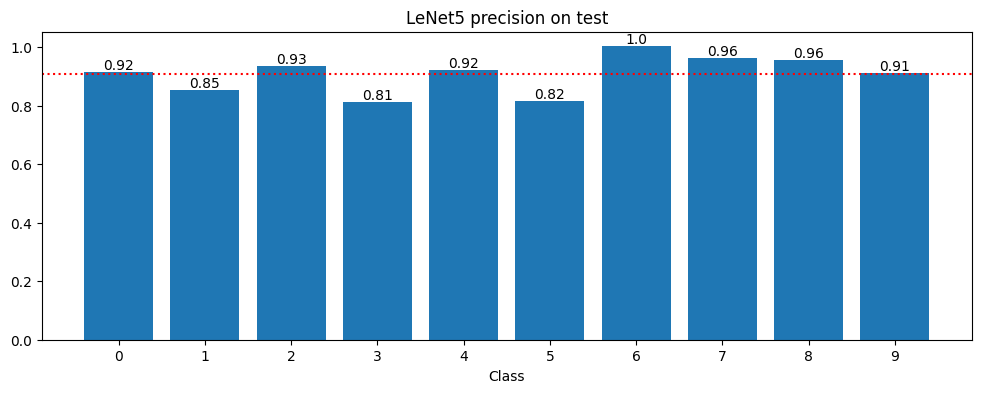

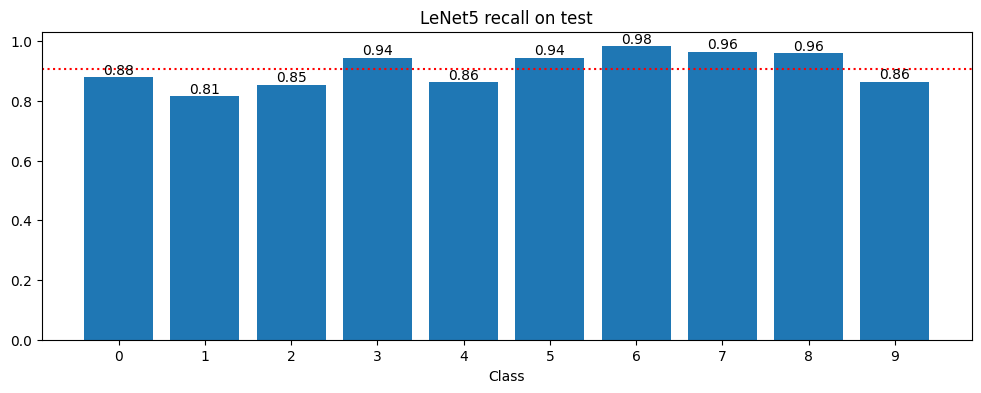

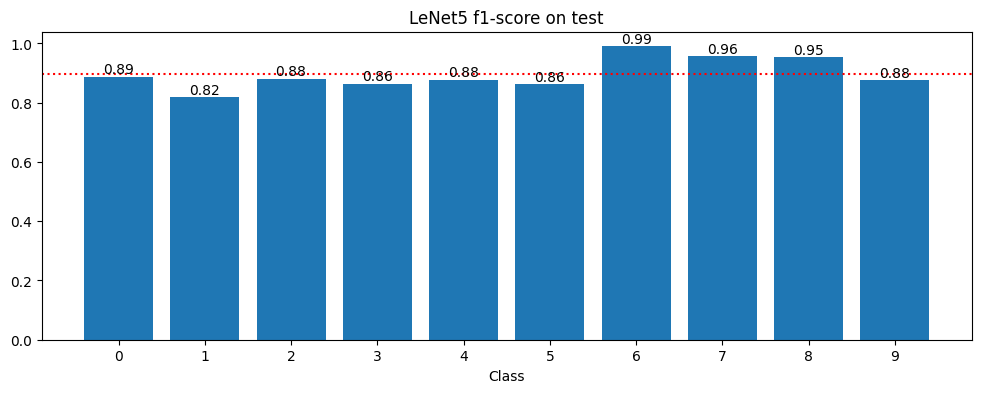

In [144]:
plot_metric_values(test_metric_values, net_name='LeNet5')